In [0]:
from IPython.display import Image

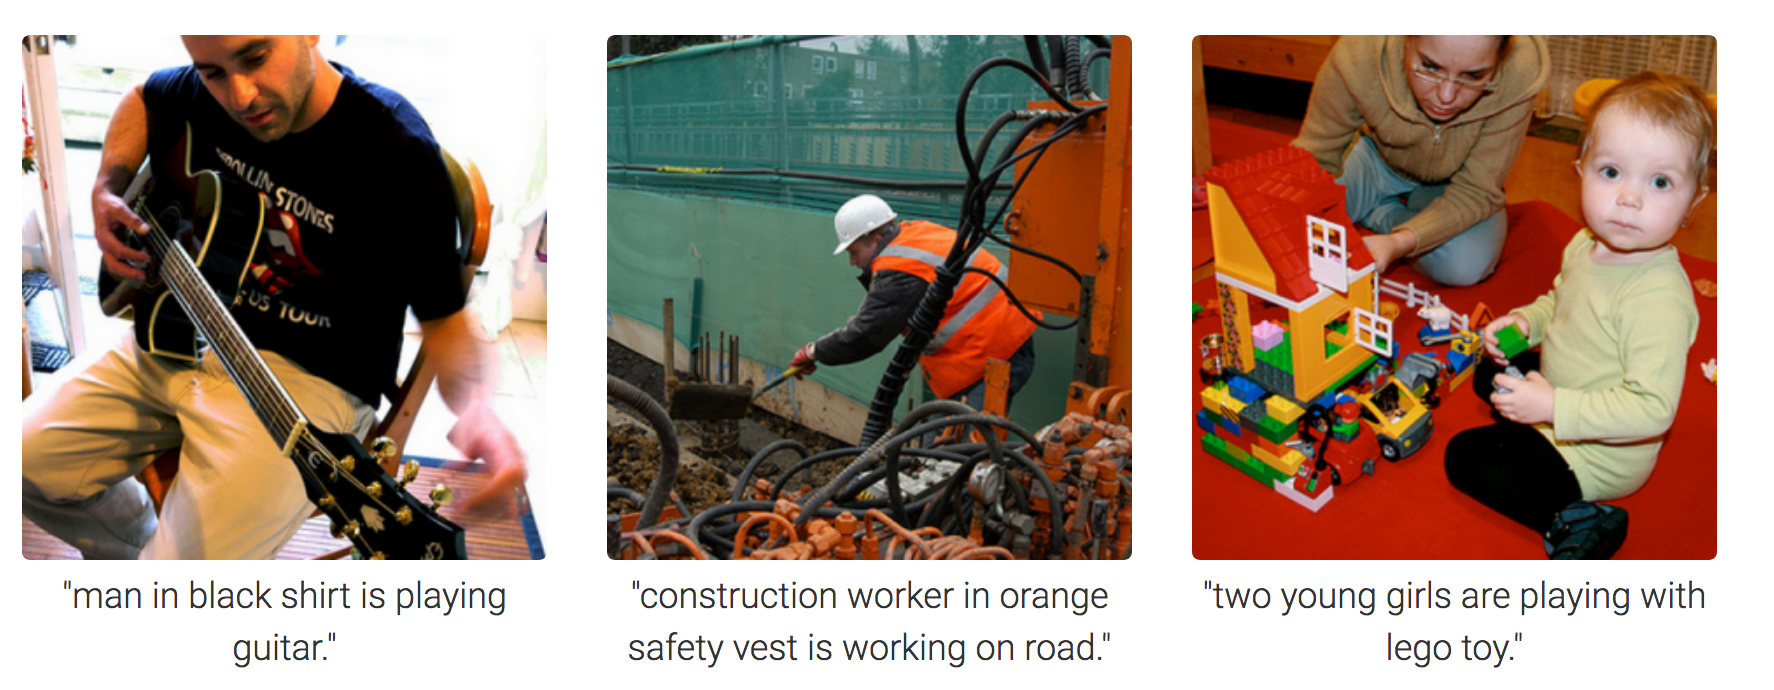

In [0]:
Image(filename = "img/header.png", width = 1000, height = 800)

# Abstract

In this notebook, I present an implementation of an image captioning neural network model, consisting of a pre-trained CNN for feature extraction, pre-trained embeddings for encoding word meanings, an RNN for linguistic representations and a simple dense decoder. The encoder-decoder architecture follows the merge method, meaning that the RNN layer is only responsible for the encoding of text rather than text generation.

In [0]:
%matplotlib inline

In [0]:
from google.colab import drive

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil
import string
import glob
import pickle
from pickle import dump
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import datetime

from skimage.io import imread

import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import get_file, to_categorical

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Flatten, Dense, Dropout, add, Bidirectional

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

import random
np.random.seed(12345)

Using TensorFlow backend.


# Background



Image captioning is an interesting computer vision problem. I first learned about it after watching a video from the Youtube channel TwoMinutePapers which covered the paper "Deep Visual-Semantic Alignments for Generating Image Descriptions" by Andrej Karpathy. At that time, I hadn't even written my first linear regression model but I was fascinated and decided that I would like to one day implement something similar.

As soon as I started work on this project, I went back to this video and the channel, and realized that there is a reversed model - where text is the input and image is the output (image generation from captions : "StackGAN: Text to Photo-realistic Image Synthesis with Stacked Generative Adversarial Networks"). This highlights the fact that in recent years image captioning has become a rather trivial problem in deep learning but its underlying motivation is more and more relevant. People are attracted to visuals as visual objects attain more attention than text - advertisements, memes, instagram, personal photo albums, as well as video - Youtube, streaming services, online courses etc. are all around us and occupy a large chunk of our free time. With this we need more advanced means to query that type of data. Algorithms that help computers 'understand' visual data and covert it to a human lanaguage help a long way in this task.

So, although trivial, my main motivation to pursue this as my first neural network project is the fact that the work touches upon key concepts such as convolutional and recurrent neural networks, transfer learning and embeddings, and text processing which are all areas that I would like to dive deeper in.

In [0]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
tf.test.gpu_device_name() 

'/device:GPU:0'

In [0]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_dir = "/content/drive/My Drive/Image_Captioning/flickr30k_images"
train_dir = "/content/drive/My Drive/Image_Captioning/flickr30k_images/flickr30k_images_train"
val_dir = "/content/drive/My Drive/Image_Captioning/flickr30k_images/flickr30k_images_val"
test_dir = "/content/drive/My Drive/Image_Captioning/flickr30k_images/flickr30k_images_test"
text_dir = "/content/drive/My Drive/Image_Captioning/flickr30k_images/Flickr30k_text/results.csv"
glove_dir = "/content/drive/My Drive/Image_Captioning/Glove"
logdir = os.path.join(root_dir, "log_dir")

# Data Preparation and Analysis

The dataset that was used for training and evaluation is the Flickr30k dataset (obtained from https://www.kaggle.com/hsankesara/flickr-image-dataset) which contains a bit more than 30 000 pictures taken from the website flickr.com. Most of the images come up with a set of 5 captions - all human-generated. 

The data is split into a training, validation and testing split, so the validation and testing sets are both roughly 15% of the entire dataset. 

In [0]:
# train (~70%), val (~15%), test split (~15)

if len(train_dir) == 0:
    files = os.listdir(root_dir)
    for f in files:
        if np.random.rand(1) < 0.15:
            shutil.move(train_dir + '/'+ f, test_dir + '/'+ f)
else:
    print('Training data has already been created')

Training data has already been created


In [0]:
# train (~70%), val (~15%), test split (~15)

if len(val_dir) == 0:
    files = os.listdir(train_dir)
    for f in files:
        if np.random.rand(1) < 0.15:
            shutil.move(train_dir + '/'+ f, val_dir + '/'+ f)
else:
    print('Validation data has already been created')

Validation data has already been created


As with any machine learning model, it is best that the input data is sparkling clean. Here, only the text data has been cleaned up - by removing non alphabetic characters and converting all words to lowercase.

In [0]:
with open(text_dir, encoding= "utf8") as fp:
    data = fp.read()

In [0]:
null_punct = str.maketrans('', '', string.punctuation)
all_captions = dict()
max_len = 0

In [0]:
# cleanup the captions

for line in data.split('\n'):
    token = line.split()
    if len(line) >= 2:
        id = token[0].split('.')[0] 
        desc = token[2:]
        
        desc = [word.lower() for word in desc]
        desc = [w.translate(null_punct) for w in desc]
        desc = [word for word in desc if word.isalpha()]

        max_len = max(max_len, len(desc))

        if id not in all_captions:
            all_captions[id] = list()
    
        all_captions[id].append(' '.join(desc))

In [0]:
print(len(all_captions)) # How many unique words
print(max_len) # Maximum length of a caption (in words)

32333
78


In [0]:
all_captions["1000092795"]

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'two young white males are outside near many bushes',
 'two men in green shirts are standing in a yard',
 'a man in a blue shirt standing in a garden',
 'two friends enjoy time spent together']

In [0]:
# prepare captions for WordCloud visual

all_tokens = []

for value in all_captions.values():
    tokenized_sents = [word_tokenize(i) for i in value]
    for i in tokenized_sents:
        all_tokens.append(i)

all_tokens_flat = []

for sublist in all_tokens:
    for item in sublist:
        all_tokens_flat.append(item)

By observing the list of the 50 most used words across all captions in the dataset, it can be inferred that most of the images capture human or animal activity - "wearing", "sitting", "standing", "playing", "walking", "holding", "looking". Another popular semantic are color desciptions of people's clothes (e.g "A man in a blue shirt").

In [0]:
stopwords = list(STOPWORDS)
all_tokens_dict=Counter(all_tokens_flat)

In [0]:
def clean_stop(stop, dic):
    for key in stop:
        if key in dic:
            del dic[key]

In [0]:
clean_stop(stopwords,all_tokens_dict)

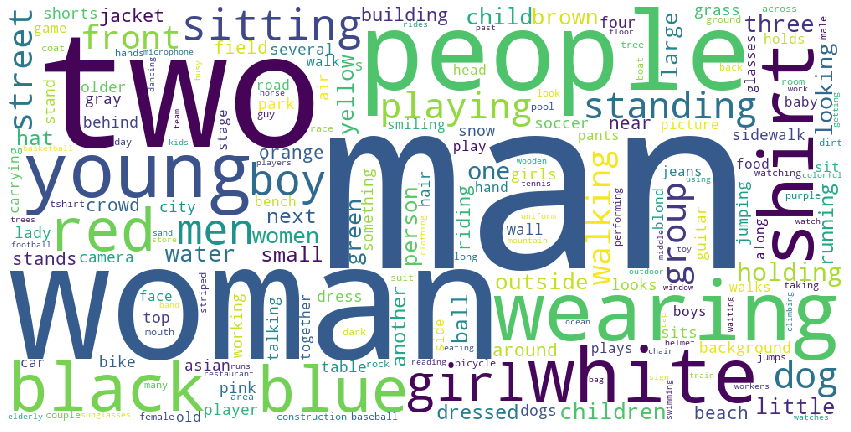

In [0]:
# plot WordCloud

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white', collocations = False).generate_from_frequencies(all_tokens_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
# most common words by occurence in the entire dataset (no stopwords)

all_tokens_dict.most_common(50)

[('man', 42598),
 ('woman', 22211),
 ('two', 21642),
 ('people', 17337),
 ('wearing', 15709),
 ('young', 13218),
 ('white', 13178),
 ('shirt', 12981),
 ('black', 12311),
 ('blue', 11310),
 ('red', 9916),
 ('girl', 9655),
 ('sitting', 9620),
 ('men', 9498),
 ('boy', 9429),
 ('standing', 9113),
 ('dog', 9090),
 ('playing', 8620),
 ('street', 7998),
 ('group', 7852),
 ('front', 7604),
 ('walking', 7339),
 ('holding', 6985),
 ('one', 6484),
 ('water', 5957),
 ('three', 5770),
 ('women', 5275),
 ('green', 5221),
 ('child', 5078),
 ('looking', 5067),
 ('little', 4794),
 ('large', 4753),
 ('outside', 4702),
 ('yellow', 4557),
 ('person', 4479),
 ('children', 4454),
 ('brown', 4446),
 ('hat', 4037),
 ('ball', 3892),
 ('small', 3779),
 ('next', 3752),
 ('dressed', 3462),
 ('another', 3372),
 ('running', 3369),
 ('building', 3360),
 ('jacket', 3348),
 ('riding', 3313),
 ('around', 3134),
 ('orange', 3086),
 ('near', 3016)]

In [0]:
# get only the train and test images jpeg names

train_img = glob.glob(os.path.join(root_dir, "flickr30k_images_train", "*.jpg"))
val_img = glob.glob(os.path.join(root_dir, "flickr30k_images_val", "*.jpg"))
test_img = glob.glob(os.path.join(root_dir, "flickr30k_images_test", "*.jpg"))

train_images = []
val_images = []
test_images = []

for i in train_img:
    f = os.path.split(i)[-1]
    train_images.append(f)

for i in val_img:
    f = os.path.split(i)[-1]
    val_images.append(f) 

for i in test_img:
    f = os.path.split(i)[-1]
    test_images.append(f) 

In [0]:
# check length of train, val and test images

print(len(train_images))
print(len(val_images))
print(len(test_images))

22962
4060
4779


After splitting the image and text data in traning, validation and test lists, two additional words are added to all captions - "STARTSEQ" and "ENDSEQ", which will use as the start/ stop triggers for caption generation.

From the entire set of captions a vocabulary is created where the individual words are indexed and only kept if they have occured at least five times in the dataset. The vocabulary will then be used to get pre-trained word embeddings using the Glove model.

In [0]:
# encode each caption with a start and stop token

start = "STARTSEQ"
stop = "ENDSEQ"

all_captions_marked = {k:v for k,v in all_captions.items() if f'{k}.jpg' in train_images}

for n,v in all_captions_marked.items(): 
    for d in range(len(v)):
        v[d] = f'{start} {v[d]} {stop}'

all_captions_marked_val = {k:v for k,v in all_captions.items() if f'{k}.jpg' in val_images}

for n,v in all_captions_marked_val.items(): 
    for d in range(len(v)):
        v[d] = f'{start} {v[d]} {stop}'
    
max_len += 2

In [0]:
print(len(all_captions_marked))
print(len(all_captions_marked_val))

22950
4060


In [0]:
all_train_captions = []
all_train_images = []

for key, val in all_captions_marked.items():
    for cap in val:
        all_train_captions.append(cap)
        all_train_images.append(key +".jpg")

In [0]:
len(all_train_captions)

114273

In [0]:
len(all_train_images)

114273

In [0]:
# build word vocabulary 
# keep words that occur at least 5 times in corpus

word_count_threshold = 5
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Words in train captions vocab decreased from %d to %d' % (len(word_counts), len(vocab)))

Words in train captions vocab decreased from 17311 to 6648


In [0]:
# lookup dictionaries

idx2word = {}
word2idx = {}

ix = 1
for w in vocab:
    word2idx[w] = ix
    idx2word[ix] = w
    ix += 1
    
vocab_size = len(idx2word) + 1 
vocab_size

6649

# Transfer Learning

## Feature extraction with Inception V3

The role of the Convolutional Neural Network in an image captioning problem is one of a feature extractor - it captures the 'meaning' of an image and represents it as a vector of numbers that can be then fed to or merged with a Recurrent Network.

The CNN model that was chosen for this implementation is the Inception V3, which s a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset.

Here, it has been chosen ahead of other popular CNNs such as the VGG16 or VGG19, because the 'smaller' version of the VGG contains more than 130 million parameters and its top-5 error on Imagenet is 7.3% Meanwhile, the Inception V3 model has less than 6 times the prameters of the VGG16 but its top-5 error on Imagenet is 3.46%.

In [0]:
# 299 has been used to train the Inception V3 model. Will resize the input although not required
# 2048 is the output dimension of the InveptionV3.layers[-2]

WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048

In [0]:
# load the inception model and cutoff its 'classification tail'

inception = InceptionV3(weights='imagenet')
inception = Model(inception.input, inception.layers[-2].output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
96116736/96112376 [==============================] - 3s 0us/step


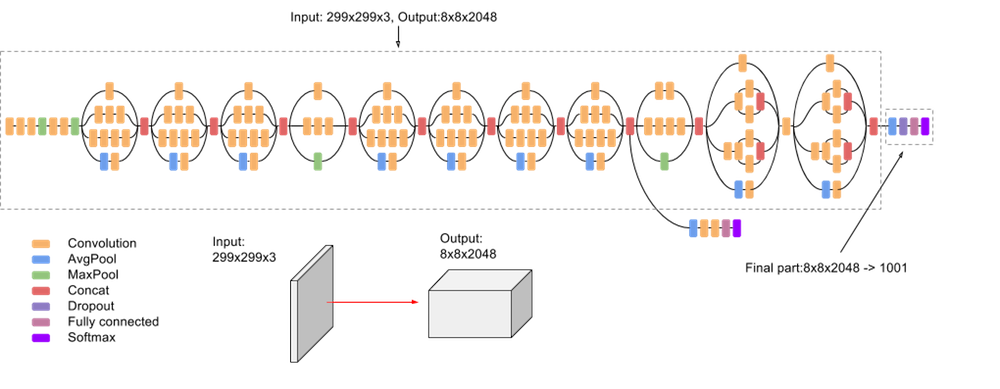

In [0]:
Image(filename = "img/inceptionv3.png", width = 1000, height = 800)

In [0]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [0]:
inception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# function to geth output from the Inception V3 CNN.

def encodeImage(img):
    # standard size
    img = img.resize((WIDTH, HEIGHT))
    # convert to numpy array
    x = tf.keras.preprocessing.image.img_to_array(img)
    # expand to 2D array
    x = np.expand_dims(x, axis=0)
    # InceptionV3 preprocessing
    x = preprocess_input(x)
    # predict
    x = inception.predict(x) # Get the encoding vector for the image
    # shape for LSTM layer
    x = np.reshape(x, OUTPUT_DIM )
    return x

Once the model is loaded, the entire image dataset is ran and the vector outputs from the vg_pool(GlobalAveragePooling2) layer are saved and ready to be used as an input in the final model.

In [0]:
# InceptionV3 outputs vectors for training images

train_path = os.path.join(root_dir,f'inception_train_2048.pkl')

if not os.path.exists(train_path):
    encoding_train = {}
    for id in tqdm(train_images):
        image_path = os.path.join(train_dir, id)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        encoding_train[id] = encodeImage(img)
    with open(train_path, "wb") as fp:
        pickle.dump(encoding_train, fp)
else:
    with open(train_path, "rb") as fp:
        encoding_train = pickle.load(fp)

In [0]:
# InceptionV3 outputs vectors for validation images

val_path = os.path.join(root_dir,f'inception_val_2048.pkl')

if not os.path.exists(val_path):
    encoding_val = {}
    for id in tqdm(val_images):
        image_path = os.path.join(val_dir, id)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        encoding_val[id] = encodeImage(img)
    with open(val_path, "wb") as fp:
        pickle.dump(encoding_val, fp)
else:
    with open(train_path, "rb") as fp:
        encoding_val = pickle.load(fp)

In [0]:
# InceptionV3 outputs vectors for testing images

test_path = os.path.join(root_dir,f'inception_test_2048.pkl')

if not os.path.exists(test_path):
    encoding_test = {}
    for id in tqdm(test_images):
        image_path = os.path.join(test_dir, id)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        encoding_test[id] = encodeImage(img)
    with open(test_path, "wb") as fp:
        pickle.dump(encoding_test, fp)
else:
    with open(test_path, "rb") as fp:
        encoding_test = pickle.load(fp)

In [0]:
encoding_train['1000092795.jpg'].shape

(2048,)

## Embedding with Glove

Besides taking advantage and saving a considerable amount of time from using transfer learning for the image features extraction with Inception V3, another instance of the transfer learning is the embedding layer.

Glove is a model for distributed word representations, and it can be used to embed a word into an N dimensional space that stores its meaning. This meaning is represented as linear substructures of the word vector space. The embedding matrix that is built here is with sizes length of the vacabulary times 300 (glove embedding dimensions). This embedding matrix is to be applied to the embedding layer of the final model, instead of training it from scratch.

In [0]:
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

400000it [00:35, 11240.69it/s]


In [0]:
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word2idx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(6649, 300)

In [0]:
# data generator for progressive loading

def data_generator(descriptions, photos, word2idx, max_len, batch_size):
  # photo_data - Training data for photos
  # caption_data - The caption that goes with each photo
  # predicted_caption_data - The predicted rest of the caption
    photo_data, caption_data, predicted_caption_data = [], [], []
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            # each photo has 5 descriptions
            for desc in desc_list:
                # convert each word into a list of sequences
                seq = [word2idx[word] for word in desc.split(' ') if word in word2idx]
                # generate a training case for every possible sequence and outcome
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    photo_data.append(photo)
                    caption_data.append(in_seq)
                    predicted_caption_data.append(out_seq)
            if n==batch_size:
                yield ([np.array(photo_data), np.array(caption_data)], np.array(predicted_caption_data))
                photo_data, caption_data, predicted_caption_data = [], [], []
                n=0

#  Model Architecture

The image captioning model implemented here has two inputs - one for the image (the output of the CNN model which is used for feature extraction) and one for the caption. The caption input has an input size of the max length of the captions in the dataset, as the data generator will feed an image with random sequences of words from the original captions.

The embedding matrix created from the Glove model is applied to the embedding layer which follows the caption input before connecting it to a bidirectional LSTM layer which serves the purpose of encoding linguistic representations. For each embedded sequence of words that the LSTM receives it returns an decoding of the most likely embedding to follow.

The encoded captions and images are then added together and decoded by a simple dense layer followed by a dense softmax activation. Dropout layers are added for both the image and text part of the model in order to avoid overfitting.

In [0]:
img_inputs = Input(shape=(OUTPUT_DIM))
img_drop = Dropout(0.5)(img_inputs)
img_dense = Dense(512, activation='relu')(img_drop)

In [0]:
cap_inputs = Input(shape=(max_len,))
embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(cap_inputs)
cap_drop = Dropout(0.5)(embedding)
bilstm = Bidirectional(LSTM(256))(cap_drop) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
decoder = add([img_dense, bilstm])
decoder_dense = Dense(512, activation='relu')(decoder)

In [0]:
outputs = Dense(vocab_size, activation='softmax')(decoder_dense)
final_model = Model(inputs=[img_inputs, cap_inputs], outputs=outputs)

In [0]:
final_model.layers[2].set_weights([embedding_matrix])
final_model.layers[2].trainable = False
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 300)      1994700     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

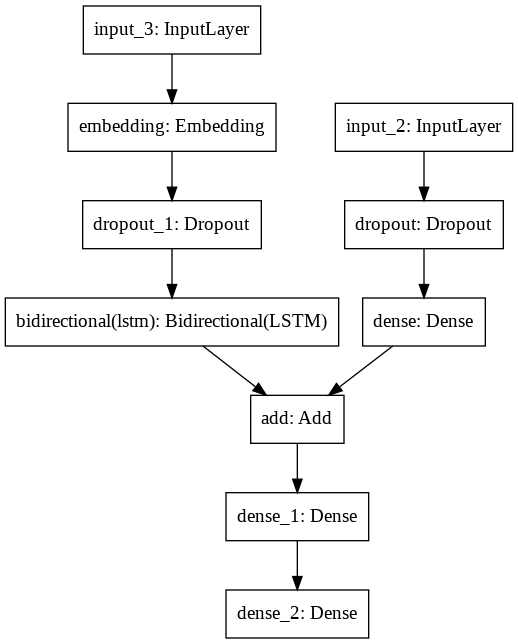

In [0]:
tf.keras.utils.plot_model(final_model)

# Training and evaluation

To train the model, a batch size of 32 is used and the model is evaluated based on the lowest loss function on the validation dataset. This is due to the intuition that if training loss keeps decreasing throughout the epochs but the validation loss starts to increase, it is likely that the model has overfitted on the training data.

After training on 10 epochs,the best validation loss was achieved on epoch number 5. The model was evaluated on the test images against the model trained for full 10 epochs and a model with an optimized learning rate of 0.0001. The later two resulted in some very accurate predictions but it seemed that the model had learned by heart some frequent ocurring sequences of words such as a "a man in a blue shirt" and applied those regardless of the image.

In [0]:
batch_size = 32
steps = len(all_captions_marked)//batch_size
val_steps = len(all_captions_marked_val)//batch_size

In [0]:
cb = TensorBoard(logdir)
#es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose =1, patience =3)
mc = ModelCheckpoint('/content/drive/My Drive/Image_Captioning/flickr30k_images/log_dir/model.{epoch:02d}-{val_loss:.2f}.hdf5',
                     monitor='val_loss', verbose=1, save_best_only=True, mode='min')
cb_list = [cb, mc] 

In [0]:
generator = data_generator(all_captions_marked, encoding_train, word2idx, max_len, batch_size)

In [0]:
generator_val = data_generator(all_captions_marked_val, encoding_val, word2idx, max_len, batch_size)

In [0]:
model_path = os.path.join(root_dir,f'caption-model_1.0.hdf5')

In [0]:
history_model_1_path = os.path.join(root_dir,f'caption-model_1.0.history')

In [0]:
if not os.path.exists(model_path):
    model_1 = final_model.fit_generator(generator, steps_per_epoch = steps,
                          validation_data = generator_val,
                          validation_steps = val_steps,
                          callbacks = cb_list, 
                          epochs = 10,
                          validation_freq = 1,
                          initial_epoch = 0)
    
    final_model.save(model_path)
    model_1_history = model_1.history
    with open(history_model_1_path, 'wb') as file_pi:
        pickle.dump(model_1_history, file_pi)

else:
    final_model.load_weights(model_path)

    with open(history_model_1_path, "rb") as fp:
        model_1_history = pickle.load(fp)

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Image_Captioning/flickr30k_images/log_dir'

By observing the loss plots it is worrying that the validation loss starts to gradually increase after only 5 epochs. This means that the model overfits the training data.

To deal with this, weight regulatization can be applied, as well as adding dropout after all dense layers or augmentating the training data.

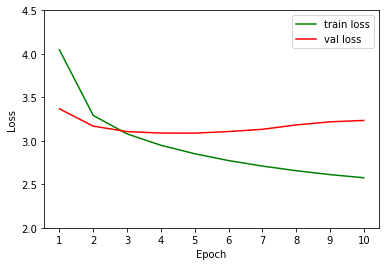

In [0]:
plt.plot(range(10), model_1_history['loss'], c ='g', label = 'train loss')
plt.plot(range(10), model_1_history['val_loss'], c ='r', label = 'val loss')
plt.legend()

plt.xticks(list(range(0, 10)), list(range(1, 11)))
plt.ylim(2, 4.5)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

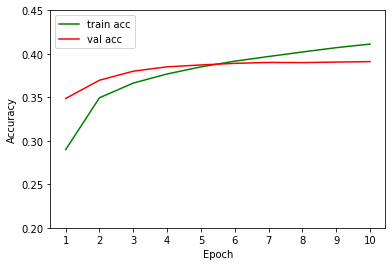

In [0]:
plt.plot(range(10), model_1_history['acc'], c ='g', label = 'train acc')
plt.plot(range(10), model_1_history['val_acc'], c ='r', label = 'val acc')
plt.legend()

plt.xticks(list(range(0, 10)), list(range(1, 11)))
plt.ylim(0.2, 0.45)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [0]:
final_model_2_path = "/content/drive/My Drive/Image_Captioning/flickr30k_images/log_dir/model.05-3.09.hdf5"

In [0]:
final_model_2 = tf.keras.models.load_model(final_model_2_path)

Let's try out a different model architecture and disconnect the dropout layers from the input layers with the belief that this could improve the accuracy of the model. The dropout layers act as a filter on both the caption and the image and this could be an additional challenge for the learning process. In the new architecture, droputout layers would still be used but this will be further down in the model architecture, just before the merge.



In [0]:
img_inputs = Input(shape=(OUTPUT_DIM))
img_dense = Dense(512, activation='relu')(img_inputs)
img_drop = Dropout(0.5)(img_dense)

cap_inputs = Input(shape=(max_len,))
embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(cap_inputs)
bilstm = Bidirectional(LSTM(256))(embedding)
cap_drop = Dropout(0.5)(bilstm)

decoder = add([img_drop, cap_drop])
decoder_dense = Dense(512, activation='relu')(decoder)
decoder_drop = Dropout(0.5)(decoder_dense)

outputs = Dense(vocab_size, activation='softmax')(decoder_drop)
new_model = Model(inputs=[img_inputs, cap_inputs], outputs=outputs)

new_model.layers[2].set_weights([embedding_matrix])
new_model.layers[2].trainable = False
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

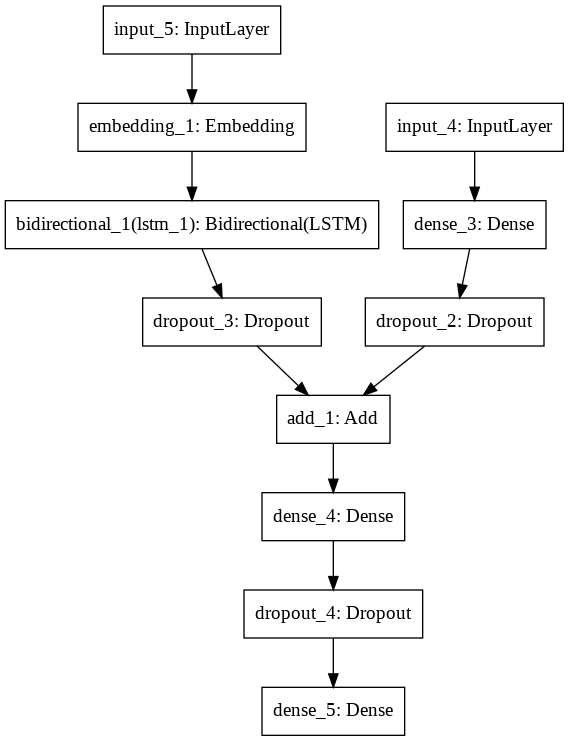

In [0]:
tf.keras.utils.plot_model(new_model)

In [0]:
new_model_path = os.path.join(root_dir,f'new_caption-model.hdf5')
history_model_2_path = os.path.join(root_dir,f'new_caption-model.history')

In [0]:
if not os.path.exists(new_model_path):
    model_2 = new_model.fit_generator(generator, steps_per_epoch = steps,
                          validation_data = generator_val,
                          validation_steps = val_steps,
                          callbacks = cb_list, 
                          epochs = 20,
                          validation_freq = 1,
                          initial_epoch = 0)
    
    new_model.save(new_model_path)
    model_2_history = model_2.history
    with open(history_model_2_path, 'wb') as file_pi:
        pickle.dump(model_2_history, file_pi)

else:
    new_model.load_weights(new_model_path)

    with open(history_model_2_path, "rb") as fp:
        model_2_history = pickle.load(fp)

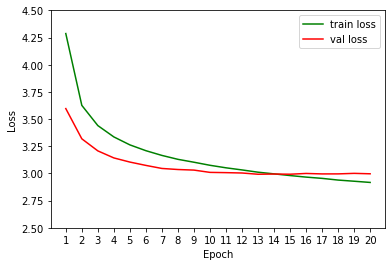

In [0]:
plt.plot(range(20), model_2_history['loss'], c ='g', label = 'train loss')
plt.plot(range(20), model_2_history['val_loss'], c ='r', label = 'val loss')
plt.legend()

plt.xticks(list(range(0, 20)), list(range(1, 21)))
plt.ylim(2.5, 4.5)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

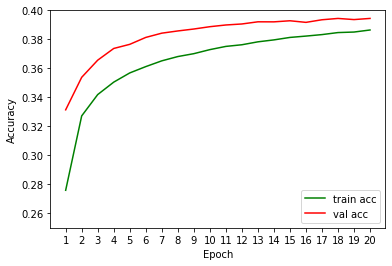

In [0]:
plt.plot(range(20), model_2_history['acc'], c ='g', label = 'train acc')
plt.plot(range(20), model_2_history['val_acc'], c ='r', label = 'val acc')
plt.legend()

plt.xticks(list(range(0, 20)), list(range(1, 21)))
plt.ylim(0.25, 0.40)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Indeed it is noted that by tweaking the dropout layers, the validation accuracy increases and the validation loss decreases with the model overfitting on epoch 15.

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Image_Captioning/flickr30k_images/log_dir'

In [0]:
new_model = tf.keras.models.load_model(new_model_path)

Two functions for captions generations have been included. The greedy search selects the single most likely word at each classification output until the end token or the max length have been reached. On the other hand, the beam search expands on this idea and returns a list of the k most likely words.

In [0]:
def generateCaption(photo):
    in_text = start
    for i in range(max_len):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = new_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == stop:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
def beam_search_predictions(image_file, beam_index = 3):
    start = [word2idx["STARTSEQ"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            now_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image_file]
            preds = new_model.predict([np.array([e]), np.array(now_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top Beam index = 3  predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'ENDSEQ':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [0]:
def random_result (z):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,OUTPUT_DIM))
    x=plt.imread(os.path.join(test_dir, pic))
    plt.imshow(x)
    plt.show()

    print(pic)
    print("Greedy Search:",generateCaption(image))
    print ('Beam Search, k=3:', beam_search_predictions(pic, beam_index=3))

# Conclusions and future work

The final model manages to generate plausible captions on the validation set, although it is far from the state of the art results on this problem. It can be noticed that although sometimes the beam search can produce more accurate descriptions this prediction approach often leads to verbosity and repetition. The model performs very well on some specific pictures as for example sports activities. 

On the other hand, the model has trouble distinguishing between a number of people in a picture. It was seen that the it often describes the activity of one person, while the picture has two or more people doing the same activity. Another problem is the correct prediction of colors, as people are described to have blue clothes when that is not the case. This can be explained due to the number of captions and photos where the color blue has been mentioned.

There are several different approaches that can be undertaken to improve this model. As the training, validation and testing sets were created with a rather hacky script I would audit the most frequent words in the three sets as a percentage of the total. This would allow to analyze wether there are any anomalities in the distributions. This suspicion is enforced by the plot of training and validation loss, where it is seen that after five epochs the validation loss starts to increase while the validation accuracy remains flattened.

Another way is to perform more optimizations on the current model. I experimented with different batch size and an optimized learning rate but this didn't lead to better results. As the model overfits quickly, some additional regularizations should be applied.

Before trying any other architectures to solve this problem, it could be worth to allow some training on the models that were used with transfer learning. Both the CNN encoder and the Glove embeddings can be trained to allow for better fit on the dataset.

Finally, there are other model architectures that can be applied to the problem. One such architecture would be the 'inject' decoder-encoder where RNN layer takes as input both the embedding and the decoded image layers. In such approach the RNN is responsible not for decoding but for generation. Other approaches may be to add multiple LSTM layers or to add an attention layer.

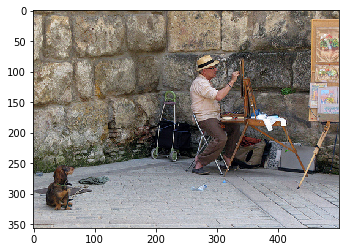

4655435447.jpg
Greedy Search: a man in a blue shirt is sitting on a bench
Beam Search, k=3: a man in a white shirt is sitting on a bench


In [0]:
random_result(random.randrange(0,len(test_images)))

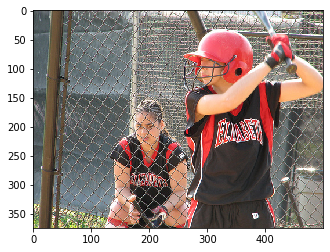

2525898056.jpg
Greedy Search: a man in a white shirt is playing a game
Beam Search, k=3: a baseball player in a blue jersey is about to catch a ball


In [0]:
random_result(random.randrange(0,len(test_images)))

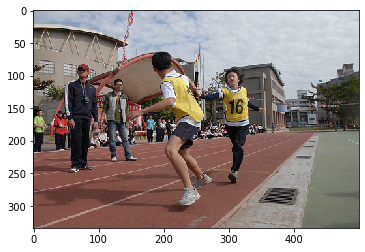

4226270513.jpg
Greedy Search: a man in a red shirt is running in a race
Beam Search, k=3: a group of people are running in a race


In [0]:
random_result(random.randrange(0,len(test_images)))

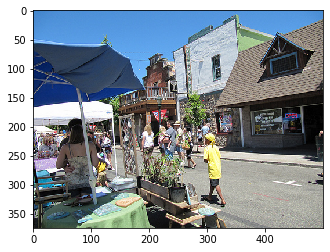

4792091734.jpg
Greedy Search: a man in a blue shirt is standing in front of a large crowd
Beam Search, k=3: a group of people are sitting on a street corner


In [0]:
random_result(random.randrange(0,len(test_images)))

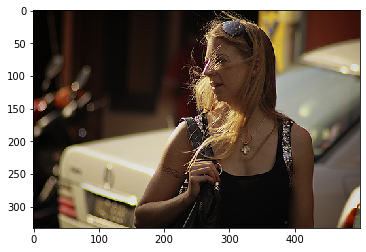

4603095253.jpg
Greedy Search: a woman in a black shirt is holding a microphone
Beam Search, k=3: a woman in a white shirt is holding a drink


In [0]:
random_result(random.randrange(0,len(test_images)))

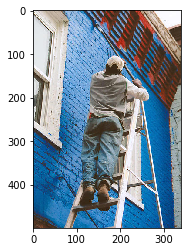

24837637.jpg
Greedy Search: a man in a blue shirt is sitting on a bench
Beam Search, k=3: a man in a blue shirt is sitting on a bench


In [0]:
random_result(random.randrange(0,len(test_images)))

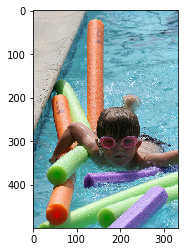

2772292098.jpg
Greedy Search: a young boy is swimming in a pool
Beam Search, k=3: a little girl in a pink bathing suit is swimming in a pool


In [0]:
random_result(random.randrange(0,len(test_images)))

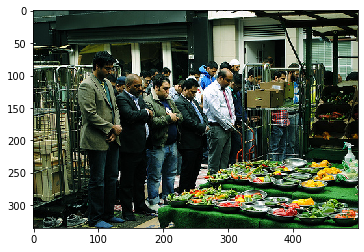

8071166084.jpg
Greedy Search: a man in a blue shirt is selling food
Beam Search, k=3: a group of people are sitting at a table in a restaurant


In [0]:
random_result(random.randrange(0,len(test_images)))

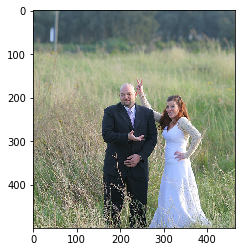

439584948.jpg
Greedy Search: a woman in a white dress is holding a bouquet of flowers
Beam Search, k=3: a woman in a white dress is holding a bouquet of flowers


In [0]:
random_result(random.randrange(0,len(test_images)))

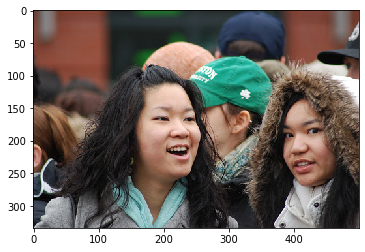

2339106348.jpg
Greedy Search: a woman in a white shirt is holding a microphone
Beam Search, k=3: a woman in a white shirt is holding a drink


In [0]:
random_result(random.randrange(0,len(test_images)))

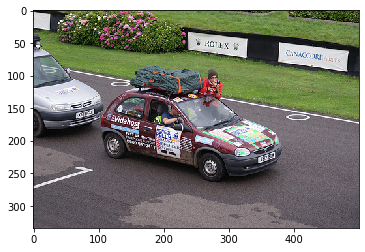

3816384696.jpg
Greedy Search: a man in a red shirt is riding a motorcycle
Beam Search, k=3: a man in a red shirt and a woman in a red shirt are riding a bike


In [0]:
random_result(random.randrange(0,len(test_images)))

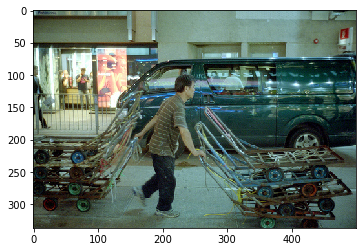

4780590314.jpg
Greedy Search: a man in a blue shirt is riding a bicycle
Beam Search, k=3: a man in a blue shirt is sitting on a bike


In [0]:
random_result(random.randrange(0,len(test_images)))

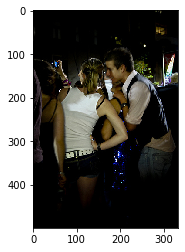

3336759846.jpg
Greedy Search: a woman in a white shirt is holding a microphone
Beam Search, k=3: a woman in a white shirt is holding a drink


In [0]:
random_result(random.randrange(0,len(test_images)))

# References



1.   Image Captioning Implementation - by Jeff Heaton
> https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb


2.   Inject vs Merge Encoder Decoder architectures - by Jason Brownlee
> https://machinelearningmastery.com/caption-generation-inject-merge-architectures-encoder-decoder-model/

3. Connecting Images and Natural Language - by Andrej Karpathy
> https://cs.stanford.edu/people/karpathy/main.pdf






